## DIY Figure 1

In this notebook, we shown how to use the theoretical approximation to obtain accurate estimates of the angular error for the paleopole estimation for different choices of parameters. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as colors
from itertools import product


import smpsite as smp

%matplotlib inline

/tmp/ipykernel_4124/2909491422.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


### Model parameters 

We first select the parameters we want to compare. 

In [11]:
site_lat = 30             # Site latitude
site_long = 0             # Site longitude
kappa_within_site = 50    # Concentration parameter kappa in each site

N_max, n0_max = 40, 20    # Maximum values of sites and samples per site

In [12]:
N_flat = np.tile(np.arange(1, N_max+1, 1), (n0_max,1)).ravel()
n0_flat = np.tile(np.arange(1, n0_max+1, 1), (N_max,1)).T.ravel()

df = pd.DataFrame({'N' : N_flat, 'n0' : n0_flat})

df["error_kappa_theoretical"] = df.apply(lambda row: smp.kappa_theoretical(smp.Params(N=row.N, 
                                                                                      n0=row.n0, 
                                                                                      kappa_within_site=kappa_within_site,
                                                                                      site_lat=site_lat,
                                                                                      site_long=site_long, 
                                                                                      outlier_rate=0.0, 
                                                                                      secular_method='G', 
                                                                                      kappa_secular=None)), axis=1)

df["error_angle_theoretical"] = df.apply(lambda row: float(smp.kappa2angular(row.error_kappa_theoretical)), axis=1)
df.head(5)

,N,n0,error_kappa_theoretical,error_angle_theoretical
0,1,1,18.528499,19.134249
1,2,1,35.056998,13.793211
2,3,1,52.585497,11.204579
3,4,1,70.113995,9.690172
4,5,1,87.642494,8.676167


### Figure

We define a function that will make the heatmap. 

In [13]:
def find_nearest(A, a0):
    """
    Function to round all the values in a generic numpy array A to the closest value in another array n0.
    """
    a = A.flatten()
    idx = ((np.tile(a, (len(a0),1)).T - a0)**2).argmin(axis=1)
    return a0[idx].reshape(A.shape)

def plot_angle_error(df, df_in=None, save_plot=True):
    
    fig, axes = plt.subplots()
    fig.set_size_inches(14, 10)
    
    caxes    = axes.inset_axes([1.04, 0.26, 0.03, 0.4])
    
    def contour_plot(df_, ax, cax, bounds, cmap, cbar_title, make_levels=True, make_contours=True, color_max=16, ticks=None, xmax=40):
    
        X = df_.columns.values
        Y = df_.index.values
        Z = df_.values
        Z_smooth = gaussian_filter(Z, 1.0)
    
        Z = np.clip(Z, a_min=0.0, a_max=color_max)
        # Z_rounded = np.rint(Z)
        mid_points = (bounds[1:] + bounds[:-1]) / 2
        Z_rounded = find_nearest(Z, mid_points)
        Z_rounded[np.isnan(Z)] = 0

        x,y = np.meshgrid(X, Y)

        if make_levels:
            N = x * y
            levels = np.hstack([np.arange(0.0, 100.0, 20), np.arange(100.0, 310, 40.)])
            IsoNLines = ax.contour(x, y, N, 10, colors='white', linestyles="dashed", levels=levels)
            ax.clabel(IsoNLines, inline=True, fontsize=10)

        ColorGrid = ax.pcolormesh(x, y, Z_rounded, cmap=cmap, norm=colors.LogNorm(vmin=2, vmax=color_max), alpha=0.8)
        
        if make_contours:
            ContourLines = ax.contour(x, y, Z, 10, colors='k', levels=bounds)  
            ax.clabel(ContourLines, inline=True, fontsize=14)

        ax.set_xlim([0, 20])
        ax.set_ylim([0, 40])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticks([1,2,3,4,5,6,7,10,15])
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
    
        cbar = plt.colorbar(ColorGrid, cax=cax, boundaries=bounds, orientation='vertical')#, fraction=0.02, location='right')
        cbar.set_label(cbar_title, rotation=270, fontsize=20, labelpad=20)
     
        return None
    
    contour_plot(df, 
                 axes, 
                 cax=caxes,
                 bounds=np.hstack([np.arange(0.0, 5.0, 0.5), np.arange(5.0, 8, 1.0), np.arange(8.0, 16.0, 2.0)]), 
                 cmap='viridis', 
                 cbar_title="RMSE for pole estimation (degrees)",
                 color_max=14, 
                 ticks=[1, 4, 7, 10, 15, 20, 30, 40])

     
    if save_plot:
        plt.savefig("Figure1.png", dpi=300, format="png", bbox_inches='tight')
        plt.savefig("Figure1.pdf", format="pdf", bbox_inches='tight')
    else: 
        plt.show()

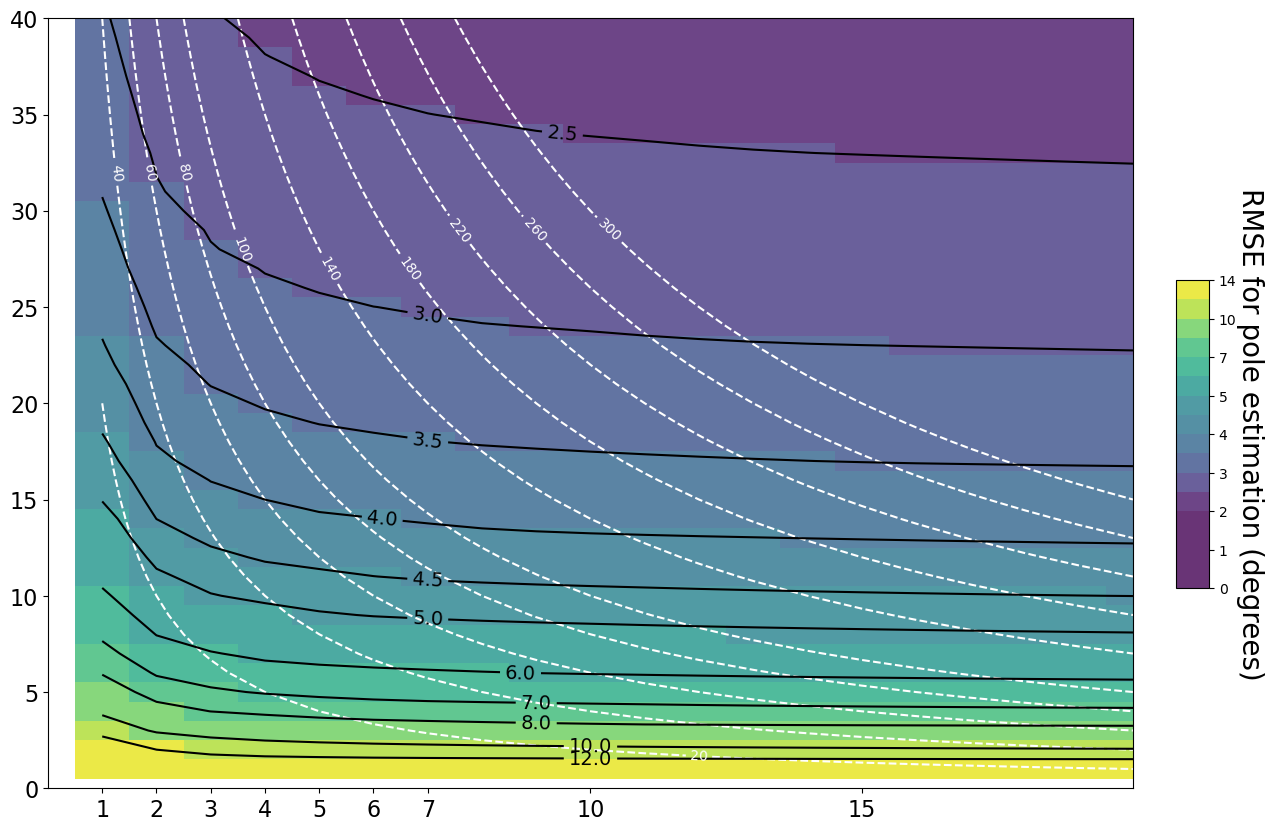

In [14]:
df_pivot = df.pivot('N', 'n0', 'error_angle_theoretical')

plot_angle_error(df_pivot, 
                 df_pivot,
                 save_plot=True)